In [2]:
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

Making Synthetic Data

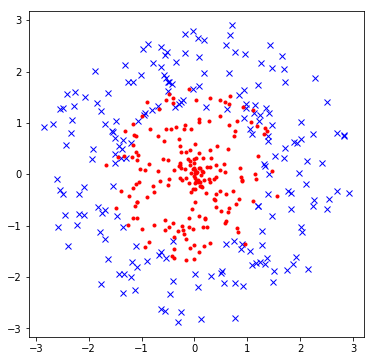

In [4]:
pos_a = np.random.uniform(low=0, high=2*np.pi, size=200)
pos_b = np.random.uniform(low=1.3, high=3, size=200)
neg_a = np.random.uniform(low=0, high=2*np.pi, size=200)
neg_b = np.random.uniform(low=0, high=1.7, size=200)

def cart(l, n):
    x = l * np.cos(n)
    y = l * np.sin(n)
    return(x, y)
pos_x, pos_y = cart(pos_b, pos_a)
neg_x, neg_y = cart(neg_b, neg_a)
plt.figure(figsize=(6,6))
plt.plot(pos_x, pos_y, 'bx')
plt.plot(neg_x, neg_y, 'r.')

In [263]:
"""Kernel functions"""
def K_Gauss(x, y, gamma):
    K = np.exp(- gamma * (np.linalg.norm(x - y) ** 2))
    return K
def K_Laplace(x, y, sigma):
    K = np.exp(- np.linalg.norm(x - y) / sigma)
    return K

def F(x, y, i, alpha, b, kernel_type = 'Laplace'):
    F = 0
    if kernel_type == 'Gaussian':
        for j in range(np.size(y)):
            F += alpha[j] * y[j] * K_Gauss(x[j], x[i], gamma_gauss)
    elif kernel_type == 'Laplace':
        for j in range(np.size(y)):
            F += alpha[j] * y[j] * K_Laplace(x[j], x[i], sigma)
    return F + b

def predict(x, y, point, alpha, b, kernel_type = 'Laplace'):
    F_tot = 0
    if kernel_type == 'Gaussian':
        for j in range(np.size(y)):
            F_tot += alpha[j] * y[j] * K_Gauss(x[j], point, gamma_gauss)
    elif kernel_type == 'Laplace':
        for j in range(np.size(y)):
            F_tot += alpha[j] * y[j] * K_Laplace(x[j], point, sigma)
    ff = F_tot + b
    if ff >= 0:
        return 1
    if ff < 0:
        return -1

In [5]:
def SMO(C, tol, max_cycle, x, y, kernel_type = 'Gaussian'):
    
    def give_b(kernel_type):
        if kernel_type == 'Gaussian':
            b1 = b - E_i - y[i] * (alpha[i] - alpha_prev_i) * K_Gauss(x[i], x[i], gamma_gauss) 
            - y[j] * (alpha[j] - alpha_prev_j) * K_Gauss(x[j], x[j], gamma_gauss)
            b2 = b - E_j - y[i] * (alpha[i] - alpha_prev_i) * K_Gauss(x[i], x[i], gamma_gauss) 
            - y[j] * (alpha[j] - alpha_prev_j) * K_Gauss(x[j], x[j], gamma_gauss)
        elif kernel_type == 'Laplace':
            b1 = b - E_i - y[i] * (alpha[i] - alpha_prev_i) * K_Laplace(x[i], x[i], sigma) 
            - y[j] * (alpha[j] - alpha_prev_j) * K_Laplace(x[j], x[j], sigma)
            b2 = b - E_j - y[i] * (alpha[i] - alpha_prev_i) * K_Laplace(x[i], x[i], sigma) 
            - y[j] * (alpha[j] - alpha_prev_j) * K_Laplace(x[j], x[j], sigma)
        return b1, b2
    
    def give_eta(kernel_type):
        if kernel_type == 'Gaussian':
            eta = 2 * K_Gauss(x[i], x[j], gamma_gauss) - K_Gauss(
                x[i], x[i], gamma_gauss) - K_Gauss(x[j], x[j], gamma_gauss)
        elif kernel_type == 'Laplace':
            eta = 2 * K_Laplace(x[i], x[j], sigma) - K_Laplace(
                x[i], x[i], sigma) - K_Laplace(x[j], x[j], sigma)    
        return eta
    
    cycle = 0
    b = 0
    N = np.size(y)
    total_t = 0
    k = 0
    alpha = np.ones(np.size(y))
    alpha_prev = np.ones(np.size(y))
    ALPHAS = []
    while (cycle< max_cycle and np.linalg.norm(
        alpha - alpha_prev) / np.linalg.norm(alpha_prev) > tol) or cycle < 2:
        ALPHAS.append(np.linalg.norm(
        alpha - alpha_prev) / np.linalg.norm(alpha_prev))
        alpha_prev = np.array(list(alpha))
        with Timer() as t:
            alphas_changed = 0
            for i in range(N):
                E_i = F(x, y, i, alpha, b, kernel_type) - y[i]
                if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):

                    
                    j = random.randint(0,N - 1)
                    while j == i:
                        j = random.randint(0,N - 1)

                    
                    E_j = F(x, y, j, alpha, b, kernel_type) - y[j]
                    alpha_prev_i = alpha[i]
                    alpha_prev_j = alpha[j]
                    if y[i] == y[j]:
                        L = max([0, alpha[i] + alpha[j] - C])
                        H = min([C, alpha[i] + alpha[j]])
                    elif y[i] != y[j]:
                        L = max([0, alpha[j] - alpha[i]])
                        H = min([C, C + alpha[j] - alpha[i]])

                    if L != H:
                        eta = give_eta(kernel_type)               
                        if eta <= 0:
                            alpha[j] = alpha[j] - y[j] * (E_i - E_j) / eta
                            if alpha[j] > H:
                                alpha[j] = H
                            elif alpha[j] < L:
                                alpha[j] = L

                            if  abs(alpha[j] - alpha_prev_j) >= tol:
                                alpha[i] = alpha[i] + y[i] * y[j] * (alpha_prev_j - alpha[j])

                                
                                b1, b2 =give_b(kernel_type)
                                
                                if 0 < alpha[i] < C:
                                    b = b1
                                elif 0 < alpha[j] < C:
                                    b = b2
                                else:
                                    b = (b1 + b2) / 2
                                alphas_changed += 1


            if alphas_changed != 0:
                cycle += 1
            else:
                cycle == 0
        total_t += t.interval
    print("total iterations: ", cycle)
    print(" average time for each iteration: ", total_t / cycle, " s/iteration")
    return alpha, b

In [265]:
def ALM(C, tol, max_cycle, x, y, kernel_type = 'Gaussian'):

    max_iterations = 10000
    gamma = np.ones((N, 2)) * 0.005
    alpha = np.zeros((N,1))
    mu = 0.05
    b_or = np.ones((N,1))
    b = np.ones((N,1))
    L = np.zeros((N, N))
    U = np.zeros((N, N))
    lambda_k = 0.05
    iterations = 0
    total_time = 0
    N = np.size(y)
    A_ = np.zeros((N, N))
    A = np.zeros((N, N))
    y = np.array([list(y)]).transpose()
    x = x.transpose()
    l = np.zeros((N,1))
    u = np.ones((N,1))
    

    while iterations < max_iterations:
        with Timer() as t:
            alpha_prev = np.array(list(alpha))
            for i in range(N):
                for j in range(N):
                    if kernel_type == 'Gaussian':
                        kij = K_Gauss(x[:, i], x[:, j], gamma_gauss)
                    elif kernel_type == 'Laplace':
                        kij = K_Laplace(x[:, i], x[:, j], sigma)
                    A_[i, j] = kij * y[i] * y[j]
                    if i == j:
                        if gamma[i, 0] + mu * (l[i] - alpha[i]) < 0:
                            L[i, j] = 0
                        else:
                            L[i, j] = 1
                        if gamma[i, 0] + mu * (alpha[i] - u[i]) < 0:
                            U[i, j] = 0
                        else:
                            U[i, j] = 1
            A = A_ + mu * (y.dot(y.transpose()) + L + U)
            b = b_or - lambda_k * y + L.dot(
                mu * l + np.array([gamma[:, 0]]).transpose()) + U.dot(
                    mu * u - np.array([gamma[:, 1]]).transpose())
            #CG
            r = b - A.dot(alpha)
            p = r
            k = 0
            while np.linalg.norm(
                b - A.dot(alpha)) / np.linalg.norm(b) > tol and k < 10000:
                r_prev = r
                a = r.transpose().dot(r) / p.transpose().dot(A).dot(p)
                alpha = alpha + a * p
                r = r - a * A.dot(p)
                beta = r.transpose().dot(r) / r_prev.transpose().dot(r_prev)
                p = r + beta * p
                k += 1
            #Loop breaks
            non_negativity = True
            for i in range(N):
                if alpha[i] < 0 or alpha[i] > C:
                    non_negativity = False
            if non_negativity and alpha.transpose().dot(y) < tol:
                break

            # Parameters are ready for next
            lambda_k = lambda_k + mu * alpha.transpose().dot(y)
            for i in range(N):
                gamma[i, 0] = max([0, gamma[i, 0] + mu * (l[i] - alpha[i])])
                gamma[i, 1] = max([0, gamma[i, 1] + mu * (alpha[i] - u[i])])
            if alpha.transpose().dot(y) > 0.25 * alpha_prev.transpose().dot(y):
                mu = 3 * mu
            iterations += 1
        total_time += t.interval
        
    print("total iterations: ", iterations)
    print("avergage time for iteration: ", total_time / iterations, " s/iteration")
    return alpha
    

In [266]:
def predict(x, y, point, alpha, b, kernel_type = 'Gaussian'):

    F_tot = 0
    if kernel_type == 'Gaussian':
        for j in range(np.size(y)):
            F_tot += alpha[j] * y[j] * K_Gauss(x[j], point, gamma_gauss)
    elif kernel_type == 'Laplace':
        for j in range(np.size(y)):
            F_tot += alpha[j] * y[j] * K_Laplace(x[j], point, sigma)
    F_ = F_tot + b
    if F_ >= 0:
        return 1
    if F_ < 0:
        return -1
    
def B(alpha):
    s = 0
    w = 0
    b = 0
    for i in range(np.size(alpha)):
        w += alpha[i] * y[i] * x[i]
    for i in range(np.size(alpha)):
        if alpha[i] != 0:
            b += (y[i] * w.dot(x[i].transpose()) - 1) / y[i]
            s += 1
    b *= 1/s
    return b

In [267]:
x = np.zeros((400, 2))

x[0:200, 0] = pos_x
x[0:200, 1] = pos_y

x[200: , 0] = neg_x
x[200: , 1] = neg_y

y = np.zeros(400)
y[0:200] = 1
y[200: ] = -1
gamma_gauss = 3
sigma = 0.1
tol = 1e-12
max_passes = 20
C = 1

In [275]:
alpha, b = SMO(C, tol, max_passes, x, y, kernel_type = 'Laplace')

total iterations:  31
 average time for each iteration:  2.324937912725633  s/iteration


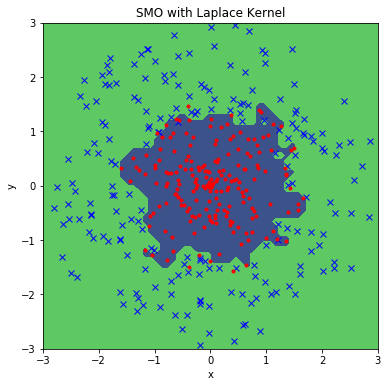

In [276]:
X = Y = np.linspace(-3, 3, 60)
Z = np.array([predict(
    x, y, np.array([i, j]), alpha, b, kernel_type = 'Laplace') for j in Y for i in X])
Z = Z.reshape(60,60)
plt.figure(figsize=(6,6))

plt.plot(pos_x, pos_y, 'bx')
plt.plot(neg_x, neg_y, 'r.')
plt.contourf(X, Y, Z, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('SMO with Laplace Kernel')

In [277]:
alpha, b = SMO(C, tol, max_passes, x, y, kernel_type = 'Gaussian')

total iterations:  98
 average time for each iteration:  2.1432418652943204  s/iteration


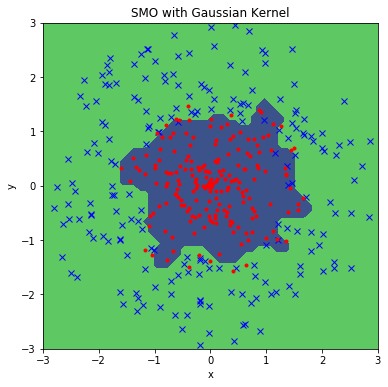

In [279]:
X = Y = np.linspace(-3, 3, 60)
Z = np.array([predict(
    x, y, np.array([i, j]), alpha, b, kernel_type = 'Gaussian') for j in Y for i in X])
Z = Z.reshape(60,60)
plt.figure(figsize=(6,6))

plt.plot(pos_x, pos_y, 'bx')
plt.plot(neg_x, neg_y, 'r.')
plt.contourf(X, Y, Z, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('SMO with Gaussian Kernel')

In [269]:
alpha = ALM(C, tol, max_passes, x, y, kernel_type = 'Laplace')

total iterations:  59
avergage time for iteration:  1.6908187017602436  s/iteration


In [270]:
b = B(alpha)

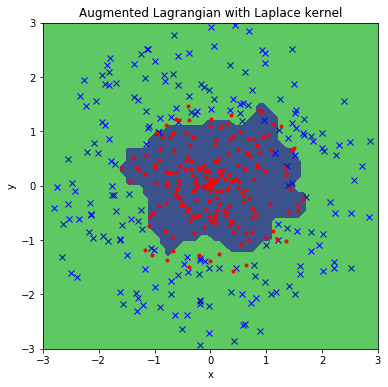

In [271]:
X = Y = np.linspace(-3, 3, 60)
Z = np.array([predict(
    x, y, np.array([i, j]), alpha, b, kernel_type = 'Laplace') for j in Y for i in X])
Z = Z.reshape(60,60)
plt.figure(figsize=(6,6))

plt.plot(pos_x, pos_y, 'bx')
plt.plot(neg_x, neg_y, 'r.')
plt.contourf(X, Y, Z, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Augmented Lagrangian with Laplace kernel')

total iterations:  75
avergage time for iteration:  1.8377479235331218  s/iteration


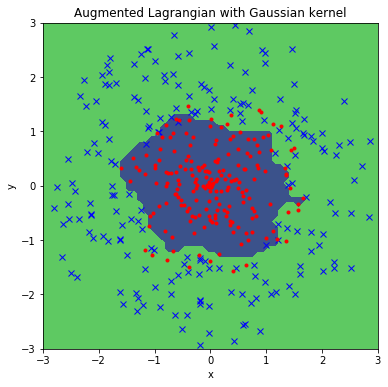

In [273]:
alpha = ALM(C, 1e-12, max_passes, x, y, kernel_type = 'Gaussian')
b = B(alpha)

X = Y = np.linspace(-3, 3, 60)
Z = np.array([predict(
    x, y, np.array([i, j]), alpha, b, kernel_type = 'Laplace') for j in Y for i in X])
Z = Z.reshape(60,60)
plt.figure(figsize=(6,6))

plt.plot(pos_x, pos_y, 'bx')
plt.plot(neg_x, neg_y, 'r.')
plt.contourf(X, Y, Z, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Augmented Lagrangian with Gaussian kernel')

Same codes but added the ALPHAS for convergence investigation

In [281]:
def SMO(C, tol, max_cycle, x, y, kernel_type = 'Gaussian'):
    
    def give_b(kernel_type):
        if kernel_type == 'Gaussian':
            b1 = b - E_i - y[i] * (
                alpha[i] - alpha_prev_i) * K_Gauss(x[i], x[i], gamma_gauss) - y[j] * (
                    alpha[j] - alpha_prev_j) * K_Gauss(x[j], x[j], gamma_gauss)
            b2 = b - E_j - y[i] * (
                alpha[i] - alpha_prev_i) * K_Gauss(x[i], x[i], gamma_gauss) - y[j] * (
                    alpha[j] - alpha_prev_j) * K_Gauss(x[j], x[j], gamma_gauss)
        elif kernel_type == 'Laplace':
            b1 = b - E_i - y[i] * (
                alpha[i] - alpha_prev_i) * K_Laplace(x[i], x[i], sigma) - y[j] * (
                    alpha[j] - alpha_prev_j) * K_Laplace(x[j], x[j], sigma)
            b2 = b - E_j - y[i] * (
                alpha[i] - alpha_prev_i) * K_Laplace(x[i], x[i], sigma) - y[j] * (
                    alpha[j] - alpha_prev_j) * K_Laplace(x[j], x[j], sigma)
        return b1, b2
    
    def give_eta(kernel_type):
        if kernel_type == 'Gaussian':
            eta = 2 * K_Gauss(x[i], x[j], gamma_gauss) - K_Gauss(
                x[i], x[i], gamma_gauss) - K_Gauss(x[j], x[j], gamma_gauss)
        elif kernel_type == 'Laplace':
            eta = 2 * K_Laplace(x[i], x[j], sigma) - K_Laplace(
                x[i], x[i], sigma) - K_Laplace(x[j], x[j], sigma)    
        return eta
    
    cycle = 0
    alpha = np.ones(np.size(y))
    alpha_prev = np.ones(np.size(y))
    b = 0
    N = np.size(y)
    total_t = 0
    k = 0
    ALPHAS = []
    while (cycle< max_cycle and np.linalg.norm(
        alpha - alpha_prev) / np.linalg.norm(alpha_prev) > tol) or cycle < 2:
        ALPHAS.append(np.linalg.norm(
        alpha - alpha_prev) / np.linalg.norm(alpha_prev))
        alpha_prev = np.array(list(alpha))
        with Timer() as t:
            alphas_changed = 0
            for i in range(N):
                E_i = F(x, y, i, alpha, b, kernel_type) - y[i]
                if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):

                    
                    j = random.randint(0,N - 1)
                    while j == i:
                        j = random.randint(0,N - 1)

                    
                    E_j = F(x, y, j, alpha, b, kernel_type) - y[j]
                    alpha_prev_i = alpha[i]
                    alpha_prev_j = alpha[j]
                    if y[i] == y[j]:
                        L = max([0, alpha[i] + alpha[j] - C])
                        H = min([C, alpha[i] + alpha[j]])
                    elif y[i] != y[j]:
                        L = max([0, alpha[j] - alpha[i]])
                        H = min([C, C + alpha[j] - alpha[i]])

                    if L != H:
                        eta = give_eta(kernel_type)               
                        if eta <= 0:
                            alpha[j] = alpha[j] - y[j] * (E_i - E_j) / eta
                            if alpha[j] > H:
                                alpha[j] = H
                            elif alpha[j] < L:
                                alpha[j] = L

                            if  abs(alpha[j] - alpha_prev_j) >= tol:
                                alpha[i] = alpha[i] + y[i] * y[j] * (alpha_prev_j - alpha[j])

                                
                                b1, b2 =give_b(kernel_type)
                                
                                if 0 < alpha[i] < C:
                                    b = b1
                                elif 0 < alpha[j] < C:
                                    b = b2
                                else:
                                    b = (b1 + b2) / 2
                                alphas_changed += 1


            if alphas_changed != 0:
                cycle += 1
            else:
                cycle == 0
        total_t += t.interval
    print("total iterations: ", cycle)
    print(" average time for each iteration: ", total_t / cycle, " s/iteration")
    return alpha, b

In [6]:
def ALM(C, tol, max_cycle, x, y, kernel_type = 'Gaussian'):

    max_iterations = 10000
    gamma = np.ones((N, 2)) * 0.005
    alpha = np.zeros((N,1))
    mu = 0.05
    b_or = np.ones((N,1))
    b = np.ones((N,1))
    L = np.zeros((N, N))
    U = np.zeros((N, N))
    lambda_k = 0.05
    iterations = 0
    total_time = 0
    N = np.size(y)
    A_ = np.zeros((N, N))
    A = np.zeros((N, N))
    y = np.array([list(y)]).transpose()
    x = x.transpose()
    l = np.zeros((N,1))
    u = np.ones((N,1))
    

    while iterations < max_iterations:
        with Timer() as t:
            alpha_prev = np.array(list(alpha))
            for i in range(N):
                for j in range(N):
                    if kernel_type == 'Gaussian':
                        kij = K_Gauss(x[:, i], x[:, j], gamma_gauss)
                    elif kernel_type == 'Laplace':
                        kij = K_Laplace(x[:, i], x[:, j], sigma)
                    A_[i, j] = kij * y[i] * y[j]
                    if i == j:
                        if gamma[i, 0] + mu * (l[i] - alpha[i]) < 0:
                            L[i, j] = 0
                        else:
                            L[i, j] = 1
                        if gamma[i, 0] + mu * (alpha[i] - u[i]) < 0:
                            U[i, j] = 0
                        else:
                            U[i, j] = 1
            A = A_ + mu * (y.dot(y.transpose()) + L + U)
            b = b_or - lambda_k * y + L.dot(
                mu * l + np.array([gamma[:, 0]]).transpose()) + U.dot(
                    mu * u - np.array([gamma[:, 1]]).transpose())
            #CG
            r = b - A.dot(alpha)
            p = r
            k = 0
            ALPHAS.append(alpha.transpose().dot(y))
            while np.linalg.norm(
                b - A.dot(alpha)) / np.linalg.norm(b) > tol and k < 10000:
                r_prev = r
                a = r.transpose().dot(r) / p.transpose().dot(A).dot(p)
                alpha = alpha + a * p
                r = r - a * A.dot(p)
                beta = r.transpose().dot(r) / r_prev.transpose().dot(r_prev)
                p = r + beta * p
                k += 1
            #Loop breaks
            non_negativity = True
            for i in range(N):
                if alpha[i] < 0 or alpha[i] > C:
                    non_negativity = False
            if non_negativity and alpha.transpose().dot(y) < tol:
                break

            # Parameters are ready for next
            lambda_k = lambda_k + mu * alpha.transpose().dot(y)
            for i in range(N):
                gamma[i, 0] = max([0, gamma[i, 0] + mu * (l[i] - alpha[i])])
                gamma[i, 1] = max([0, gamma[i, 1] + mu * (alpha[i] - u[i])])
            if alpha.transpose().dot(y) > 0.25 * alpha_prev.transpose().dot(y):
                mu = 3 * mu
            iterations += 1
        total_time += t.interval
        
    print("total iterations: ", iterations)
    print("avergage time for iteration: ", total_time / iterations, " s/iteration")
    return alpha, ALPHAS
    

In [282]:
alpha_rbf,b, ALPHAS_rbf_smo = SMO(C, tol, max_passes, x, y, kernel_type = 'Gaussian')

total iterations:  100
 average time for each iteration:  2.0825650811195375  s/iteration


In [285]:
alpha_laplace,b, ALPHAS_laplace_smo = SMO(C, tol, max_passes, x, y, kernel_type = 'Laplace')

total iterations:  35
 average time for each iteration:  2.308734164919172  s/iteration


In [311]:
alpha, ALPHAS_rbf_AL = ALM(C, tol, max_passes, x, y, kernel_type = 'Gaussian')

[[0.]]
[[7.33806244]]
[[0.45380126]]
[[0.02347869]]
[[-0.0606894]]
[[0.23662406]]
[[-0.11078816]]
[[0.09234316]]
[[-0.00929661]]
[[-0.00477618]]
[[-0.01135285]]
[[0.01456844]]
[[-0.00972812]]
[[0.01514136]]
[[-0.00121805]]
[[-0.00484317]]
[[0.00862075]]
[[-0.00119827]]
[[0.00047838]]
[[0.00064371]]
[[-0.00021465]]
[[0.00038351]]
[[-0.00019523]]
[[6.33472413e-05]]
[[1.20464345e-05]]
[[-2.46431592e-05]]
[[3.19428135e-05]]
[[-6.16911217e-06]]
[[-7.52096213e-07]]
[[-1.35598518e-06]]
[[5.12094766e-05]]
[[-1.72559448e-05]]
[[-4.01010948e-06]]
[[1.99214708e-06]]
[[-2.03839534e-07]]
[[-1.25681595e-07]]
[[4.12700018e-07]]
[[-7.72722899e-08]]
[[-1.94501411e-08]]
[[-3.71224047e-08]]
[[2.10501526e-07]]
[[-4.03112494e-08]]
[[8.95155949e-10]]
[[-6.72724809e-09]]
[[7.43148121e-09]]
[[-3.22873461e-09]]
[[5.13321652e-09]]
[[-6.33107788e-10]]
[[-4.35065317e-10]]
[[-7.7362472e-10]]
[[1.06409459e-09]]
[[-1.37532652e-10]]
[[-5.34328137e-11]]
[[-9.07505182e-11]]
[[3.58255647e-10]]
[[-8.4213525e-11]]
[[-2.77

In [327]:
alpha, ALPHAS_Laplace_AL = ALM(C, tol, max_passes, x, y, kernel_type = 'Laplace', show_time = False)

[[0.]]
[[6.54499752]]
[[0.47728069]]
[[0.03981986]]
[[0.01067504]]
[[0.00766109]]
[[0.00320092]]
[[-0.00038561]]
[[0.00365484]]
[[-0.00034393]]
[[-0.00166013]]
[[0.00207274]]
[[-0.0001856]]
[[-0.00051988]]
[[0.00116488]]
[[-0.00033223]]
[[4.8328618e-08]]
[[4.77832019e-05]]
[[-1.46188999e-05]]
[[2.44562746e-05]]
[[-1.00116787e-06]]
[[-1.19196194e-05]]
[[1.7135744e-05]]
[[-2.49336554e-06]]
[[-2.37769589e-06]]
[[3.59915499e-06]]
[[-5.08858526e-07]]
[[-8.09645024e-07]]
[[1.64719102e-06]]
[[-3.88764887e-07]]
[[-6.67652262e-08]]
[[4.41871819e-08]]
[[-4.9998965e-09]]
[[2.59323107e-08]]
[[-6.68925537e-09]]
[[-9.26650934e-09]]
[[1.90072349e-08]]
[[-2.10442241e-09]]
[[-2.3405109e-09]]
[[3.96463307e-09]]
[[-1.09806941e-09]]
[[-7.58920926e-10]]
[[2.1661215e-09]]
[[-5.2070126e-10]]
[[1.22746258e-11]]
[[4.51763071e-11]]
[[-2.1525004e-11]]
[[3.27879945e-11]]
[[-1.01012532e-11]]
[[-1.16631149e-11]]
[[3.53530538e-11]]
[[-2.92654789e-12]]
[[-7.05213665e-12]]
[[3.10933501e-11]]
[[-6.37445652e-12]]
[[-4.7

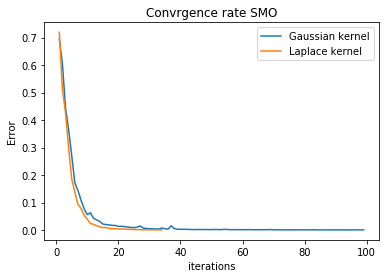

In [292]:
plt.plot(np.arange(1,len(ALPHAS_rbf_smo)) ,ALPHAS_rbf_smo[1:], label ="Gaussian kernel")
plt.plot(np.arange(1,len(ALPHAS_laplace_smo)) ,ALPHAS_laplace_smo[1:], label = "Laplace kernel")
plt.legend()
plt.title("Convrgence rate SMO")
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


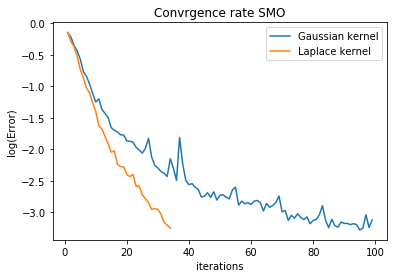

In [359]:
plt.plot(np.arange(1,len(ALPHAS_rbf_smo)) ,np.log10(ALPHAS_rbf_smo)[1:], label ="Gaussian kernel")
plt.plot(np.arange(1,len(ALPHAS_laplace_smo)) ,np.log10(ALPHAS_laplace_smo)[1:], label = "Laplace kernel")
plt.legend()
plt.title("Convrgence rate SMO")
plt.xlabel("iterations")
plt.ylabel("log(Error)")
plt.show()

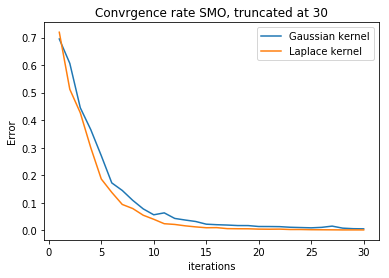

In [296]:
plt.plot(np.arange(1,31) ,ALPHAS_rbf_smo[1:31], label ="Gaussian kernel")
plt.plot(np.arange(1,31) ,ALPHAS_laplace_smo[1:31], label = "Laplace kernel")
plt.legend()
plt.title("Convrgence rate SMO, truncated at 30")
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

In [330]:
a = []
for i in ALPHAS_rbf_AL:
    a.append(i[0][0])
a

[0.0,
 7.3380624402456505,
 0.45380125922338266,
 0.023478691959780917,
 -0.06068939672104534,
 0.2366240583880881,
 -0.11078816183288609,
 0.09234315764888379,
 -0.009296607067639684,
 -0.004776175293216056,
 -0.011352849166797796,
 0.01456843772166394,
 -0.009728119714054628,
 0.01514135705340891,
 -0.0012180518413487107,
 -0.004843166409386868,
 0.00862074676172142,
 -0.0011982674504054103,
 0.00047838256438126336,
 0.0006437092737741068,
 -0.0002146545202492689,
 0.0003835061424695141,
 -0.00019522645894909374,
 6.33472413369418e-05,
 1.2046434465950995e-05,
 -2.464315917904969e-05,
 3.194281350715755e-05,
 -6.16911216866356e-06,
 -7.52096212863762e-07,
 -1.3559851836930648e-06,
 5.120947662362596e-05,
 -1.7255944840144366e-05,
 -4.010109478258528e-06,
 1.992147076634865e-06,
 -2.038395336967369e-07,
 -1.2568159490911057e-07,
 4.1270001815973956e-07,
 -7.727228990006552e-08,
 -1.945014105331211e-08,
 -3.712240470576944e-08,
 2.1050152554380475e-07,
 -4.0311249449587194e-08,
 8.9515

In [329]:
b = []
for i in ALPHAS_Laplace_AL:
    a
    b.append(i[0][0])
b

[0.0,
 6.544997515976345,
 0.4772806904067872,
 0.03981985602427107,
 0.010675041487155923,
 0.007661093699809829,
 0.003200919138599989,
 -0.0003856050371791042,
 0.003654839528586251,
 -0.000343929633914275,
 -0.0016601328384862057,
 0.0020727376163964806,
 -0.00018560213021423522,
 -0.0005198845094191995,
 0.001164880265156043,
 -0.0003322310633442349,
 4.832861799641819e-08,
 4.7783201907236617e-05,
 -1.4618899903950933e-05,
 2.445627460456734e-05,
 -1.0011678703847338e-06,
 -1.191961942392794e-05,
 1.713574397754769e-05,
 -2.4933655433656554e-06,
 -2.377695894395515e-06,
 3.5991549944824897e-06,
 -5.088585259827028e-07,
 -8.096450239136743e-07,
 1.6471910164739256e-06,
 -3.887648873934779e-07,
 -6.676522623649817e-08,
 4.418718191345761e-08,
 -4.99989649682675e-09,
 2.5932310743215226e-08,
 -6.6892553718389536e-09,
 -9.266509337635398e-09,
 1.9007234897117087e-08,
 -2.104422414106466e-09,
 -2.3405108962037957e-09,
 3.964633066289025e-09,
 -1.098069413174585e-09,
 -7.58920926102746

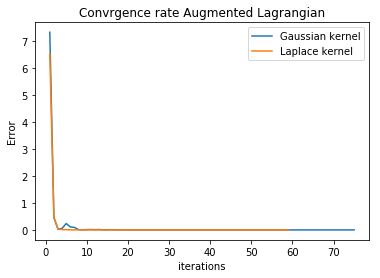

In [348]:
plt.plot(np.arange(1,len(a)) ,np.abs(a)[1:], label ="Gaussian kernel")
plt.plot(np.arange(1,len(b)) ,np.abs(b)[1:], label ="Laplace kernel")
plt.legend()
plt.title("Convrgence rate Augmented Lagrangian")
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


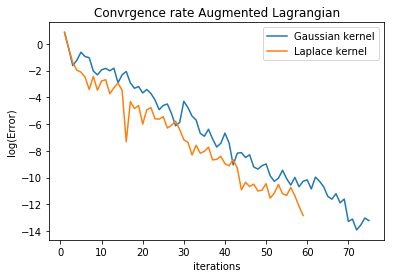

In [361]:
plt.plot(np.arange(1,len(a)) ,np.log10(np.abs(a))[1:], label ="Gaussian kernel")
plt.plot(np.arange(1,len(b)) ,np.log10(np.abs(b))[1:], label ="Laplace kernel")
plt.legend()
plt.title("Convrgence rate Augmented Lagrangian")
plt.xlabel("iterations")
plt.ylabel("log(Error)")
plt.show()

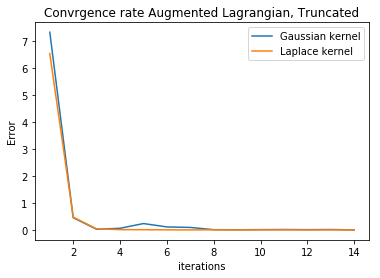

In [350]:
plt.plot(np.arange(1,15) ,np.abs(a)[1:15], label ="Gaussian kernel")
plt.plot(np.arange(1,15) ,np.abs(b)[1:15], label ="Laplace kernel")
plt.legend()
plt.title("Convrgence rate Augmented Lagrangian, Truncated")
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

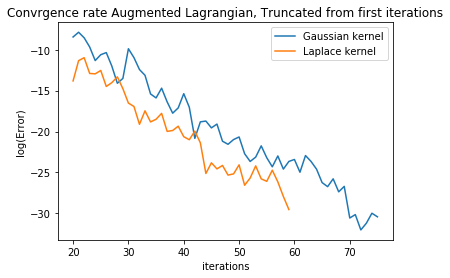

In [360]:
plt.plot(np.arange(20,len(a)) ,np.log(np.abs(a)[20:]), label ="Gaussian kernel")
plt.plot(np.arange(20,len(b)) ,np.log(np.abs(b)[20:]), label ="Laplace kernel")
plt.legend()
plt.title("Convrgence rate Augmented Lagrangian, Truncated from first iterations")
plt.xlabel("iterations")
plt.ylabel("log(Error)")
plt.show()

For MNIST, had to re-write the optmization code as a class for the way the data is processed. The code is exactly similar to one used above

In [78]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random as rnd
print(os.listdir("data_mnist"))

['mnist_train.csv', 'mnist_test.csv']


In [82]:
df = pd.read_csv('data_mnist/mnist_test.csv', dtype="int64")
#y_df = pd.read_csv('../input/mnist_test.csv', header = None)
y = df['label']
x = df.drop('label', axis=1)

In [83]:
y = y.values
x = x.values
DIGIT = 8
data_x = []
data_y = []
for index, label in enumerate(y):
    if(label == DIGIT or label == 7):
        data_x.append(x[index])
        if(label == DIGIT):
          data_y.append(1)
        else:
          data_y.append(-1) 

In [84]:
data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
print("shape of x: "+ str(data_x.shape), "shape of y: "+str(data_y.shape))

shape of x: (12116, 784) shape of y: (12116,)


In [76]:
X_train, X_test, Y_train, Y_test = tts(data_x, data_y, test_size = 0.4, random_state = 5)

In [63]:
info_counts = []
info_alphas = []
info_time = []

class SVM():
    def __init__(self, max_iter=100, kernel_type='laplacian', C=1.0, epsilon=0.001, sigma =1):
        self.kernels = {
            'gaussian' : self.kernel_gauss,
            'Laplacian': self.kernel_Laplacian
        }
        self.max_iter = max_iter
        self.C = C
        self.epsilon = epsilon
        self.sigma = sigma
        self.kernel_type = kernel_type

        def kernel_gauss(self,x1, x2):
            return np.exp(- (np.linalg.norm(x1 - x2, 2)) ** 2 / (2 * self.sigma ** 2))
        def kernel_Laplacian(self,x1,x2):
            return np.exp(- (np.linalg.norm(x1 - x2, 2)) / (self.sigma ))
        def predict_proba(self, X):
            return np.dot(self.w.T, X.T) + self.b
        
        def fit(self, X, y):

            n, d = X.shape[0], X.shape[1]
            alpha = np.zeros((n))
            kernel = self.kernels[self.kernel_type]
            count = 0
        
        while True:
            start_time = time.time()
            count += 1
            print(count)
            info_counts.append(count)
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) 
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

    
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

                
            end_time = time.time()
            info_time.append(end_time - start_time)
            diff = np.linalg.norm(alpha - alpha_prev)
            info_alphas.append(diff)
            if diff < self.epsilon:
                break
            if count >= self.max_iter:
                return
        self.b = self.calc_b(X, y, self.w)
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i







In [62]:
info_counts = []
info_alphas = []
info_time = []

model = SVM(max_iter=100, kernel_type='gaussian', C=1.0, epsilon=0.001, sigma = 0.1)
model.fit(X_train, Y_train)
Y_predicted = [model.predict(x) for x in X_test]
cm_gaussian = confusion_matrix(Y_test, Y_predicted)
cm = cm_gaussian
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(accuracy)

info_counts_gauss = info_counts
info_alphas_gauss = info_alphas
info_time_gauss = info_time

1
2
3
4
5
0.9925093632958801


In [64]:
info_counts = []
info_alphas = []
info_time = []

model = SVM(max_iter=100, kernel_type='Laplacian', C=1.0, epsilon=0.001, sigma = 0.1)
model.fit(X_train, Y_train)
Y_predicted = [model.predict(x) for x in X_test]
cm_laplace= confusion_matrix(Y_test, Y_predicted)
cm = cm_laplace
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(accuracy)

info_counts_laplace = info_counts
info_alphas_laplace = info_alphas
info_time_laplace = info_time

1
2
3
4
5
6
7
0.9900124843945068


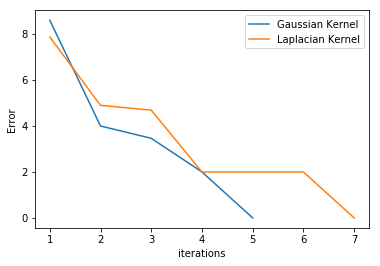

In [69]:
plt.plot(info_counts_gauss, info_alphas_gauss, label= "Gaussian Kernel")
plt.plot(info_counts_laplace, info_alphas_laplace, label= "Laplacian Kernel")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

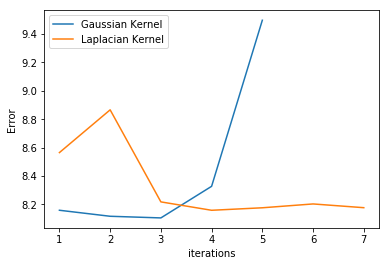

In [70]:
plt.plot(info_counts_gauss, info_time_gauss, label= "Gaussian Kernel")
plt.plot(info_counts_laplace, info_time_laplace, label= "Laplacian Kernel")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

In [95]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random as rnd
print(os.listdir("data_mnist"))

['mnist_train.csv', 'mnist_test.csv']


In [96]:
df = pd.read_csv('data_mnist/mnist_train.csv', dtype="int64")
#y_df = pd.read_csv('../input/mnist_test.csv', header = None)
y = df['label']
x = df.drop('label', axis=1)

In [97]:
y = y.values
x = x.values
DIGIT = 8
data_x = []
data_y = []
for index, label in enumerate(y):
    if(label == DIGIT or label == 7):
        data_x.append(x[index])
        if(label == DIGIT):
          data_y.append(1)
        else:
          data_y.append(-1) 

In [98]:
data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
print("shape of x: "+ str(data_x.shape), "shape of y: "+str(data_y.shape))

shape of x: (12116, 784) shape of y: (12116,)


In [99]:
X_train, X_test, Y_train, Y_test = tts(data_x, data_y, test_size = 0.2, random_state = 5)